In [1]:
# Importing necessary libaries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

In [2]:
# importing dataset
df = pd.read_excel("premiums.xlsx")
df.head(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


## Data Cleaning:

In [4]:
df.shape

(50000, 13)

In [5]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

#### Findings:
##### The column naming convention in the dataset is inconsistent, so we will standardize the column names.

In [7]:
# making all the column name lowercase and space between words are replaced with dash.

df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [8]:
# checking null value in the dataset
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

#### Findings:
##### A few null values have been found, which we will remove.

In [10]:
# dropping null values
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [11]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### Numeric value Issue Findings:
##### 1. Since the age column has a maximum value of 356, which seems suspicious, we will investigate it further.
##### 2. As the number_of_dependants column has a negative value, which seems suspicious, we will investigate it further.
##### 3. We will also look into income_lakhs and annual_premium_amount columns to check outliers.

### Handling negative values:

In [16]:
df[df["number_of_dependants"]<0].shape

(72, 13)

In [17]:
df[df["number_of_dependants"]<0]["number_of_dependants"].unique()

array([-3, -1], dtype=int64)

In [18]:
df["number_of_dependants"].value_counts()

number_of_dependants
 0    15428
 3    11006
 1     8676
 2     8418
 4     4723
 5     1653
-1       40
-3       32
Name: count, dtype: int64

##### Assuming the negative values are mistakently inputted as negitive hence we will convert it to positive values.

In [20]:
df["number_of_dependants"] = df["number_of_dependants"].abs()

In [21]:
df["number_of_dependants"].value_counts()

number_of_dependants
0    15428
3    11038
1     8716
2     8418
4     4723
5     1653
Name: count, dtype: int64

### Outlier Lookup:

In [23]:
# creating a list with numeric column names
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
numeric_columns

['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount']

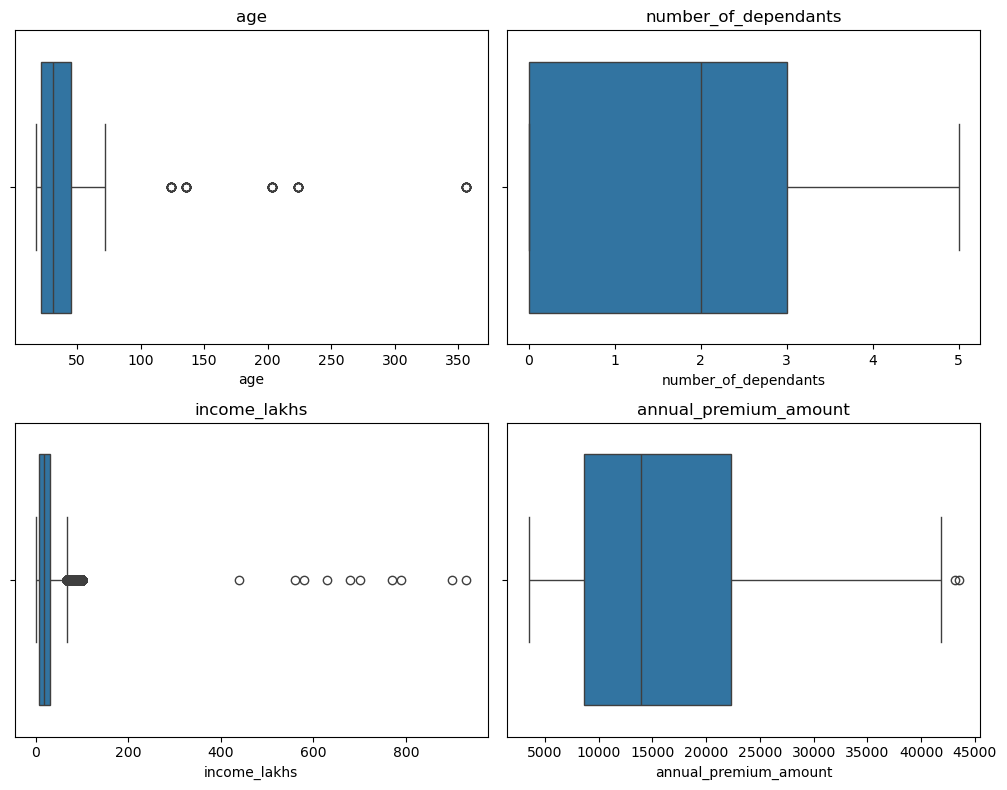

In [24]:
#Visualizing the outliers with box plot

# Define number of rows and columns for subplots
num_cols = 2  # Number of plots per row
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 4))

# Flatten axes array for easy iteration (in case of single row, make axes iterable)
axes = axes.flatten() if num_rows > 1 else [axes]

# Loop over numeric columns and plot in each subplot
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Outlier handling: Age Column

In [27]:
df[df["age"]>100]["age"].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [28]:
df1 = df[df["age"]<=100]

In [29]:
df1.age.describe()

count    49918.000000
mean        34.401839
std         13.681600
min         18.000000
25%         22.000000
50%         31.000000
75%         45.000000
max         72.000000
Name: age, dtype: float64

In [30]:
df1.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


### Outlier handling: Income Column

In [33]:
def get_iqr_bounds(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

# Example of IQR calculation (though not used in the final approach)
lower_bound, upper_bound = get_iqr_bounds(df1["income_lakhs"])
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

Lower Bound: -29.0, Upper Bound: 67.0


In [34]:
df1[df1["income_lakhs"]>upper_bound].shape

(3559, 13)

##### Upon reviewing the data with an upper limit threshold, we discovered 3,559 rows containing incomes exceeding 6.7 million. Removing this amount of data would significantly impact our overall analysis. Additionally, in real-world scenarios, some individuals earn more than 6.7 million. Therefore, we will establish a more appropriate threshold to address the outliers.

In [36]:
threshold = df1['income_lakhs'].quantile(0.999) # Using 99.9th percentile
print(f"Threshold: {threshold}")

Threshold: 100.0


In [37]:
df1[df1["income_lakhs"]>threshold].shape

(10, 13)

In [38]:
df2 = df1[df1['income_lakhs'] <= threshold].copy() # Create new dataframe with filtered income
print(df2.describe())  # Verify changes

                age  number_of_dependants  income_lakhs  annual_premium_amount
count  49908.000000          49908.000000  49908.000000           49908.000000
mean      34.401579              1.717640     22.889897           15765.739641
std       13.681604              1.492032     22.170699            8418.674061
min       18.000000              0.000000      1.000000            3501.000000
25%       22.000000              0.000000      7.000000            8608.000000
50%       31.000000              2.000000     17.000000           13928.000000
75%       45.000000              3.000000     31.000000           22270.500000
max       72.000000              5.000000    100.000000           43471.000000


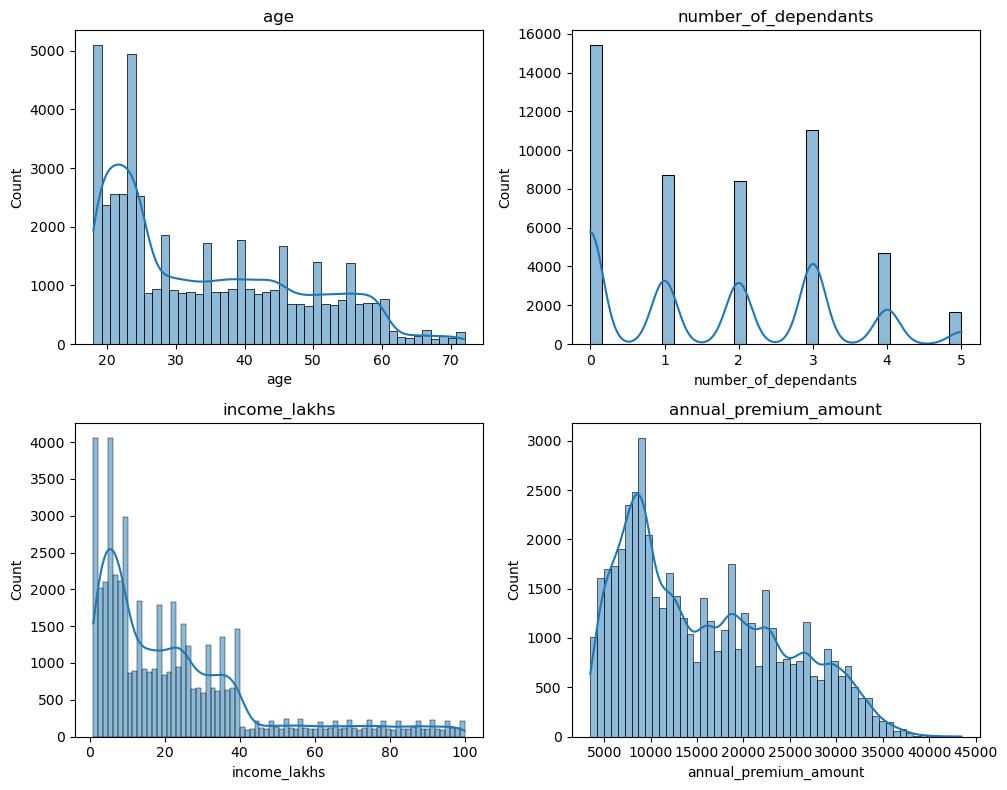

In [39]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()  # Adjust the layout
plt.show()

## Exploratory Data Analysis

### Bivariate Analysis: Numeric Columns

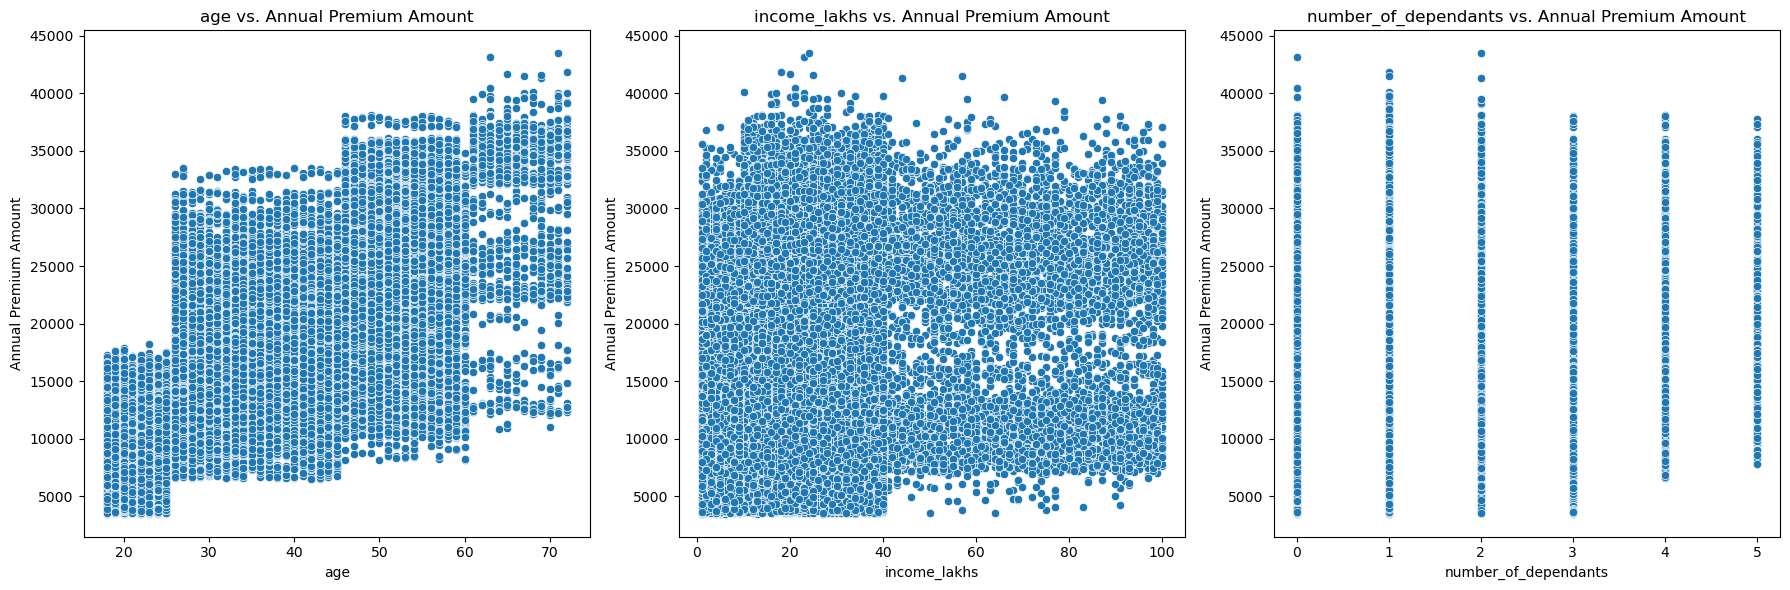

In [43]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

From the above Bivariate Analysis we found a pattern between Age and Annual Premium Amount which indication positive relationship between them. Which means when age increases premium amount also increases. 

## Categorical Columns

In [47]:
categorical_columns = df2.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')


In [48]:
# checking categorical column values
for col in categorical_columns:
    print(col, ":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


### Adjusting Values: Smoking Status Column

In [50]:
df2['smoking_status'] = df2['smoking_status'].replace({"Smoking=0":"No Smoking",'Does Not Smoke':"No Smoking",
 'Not Smoking':"No Smoking"})
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Univariate Analysis: Categorical Columns

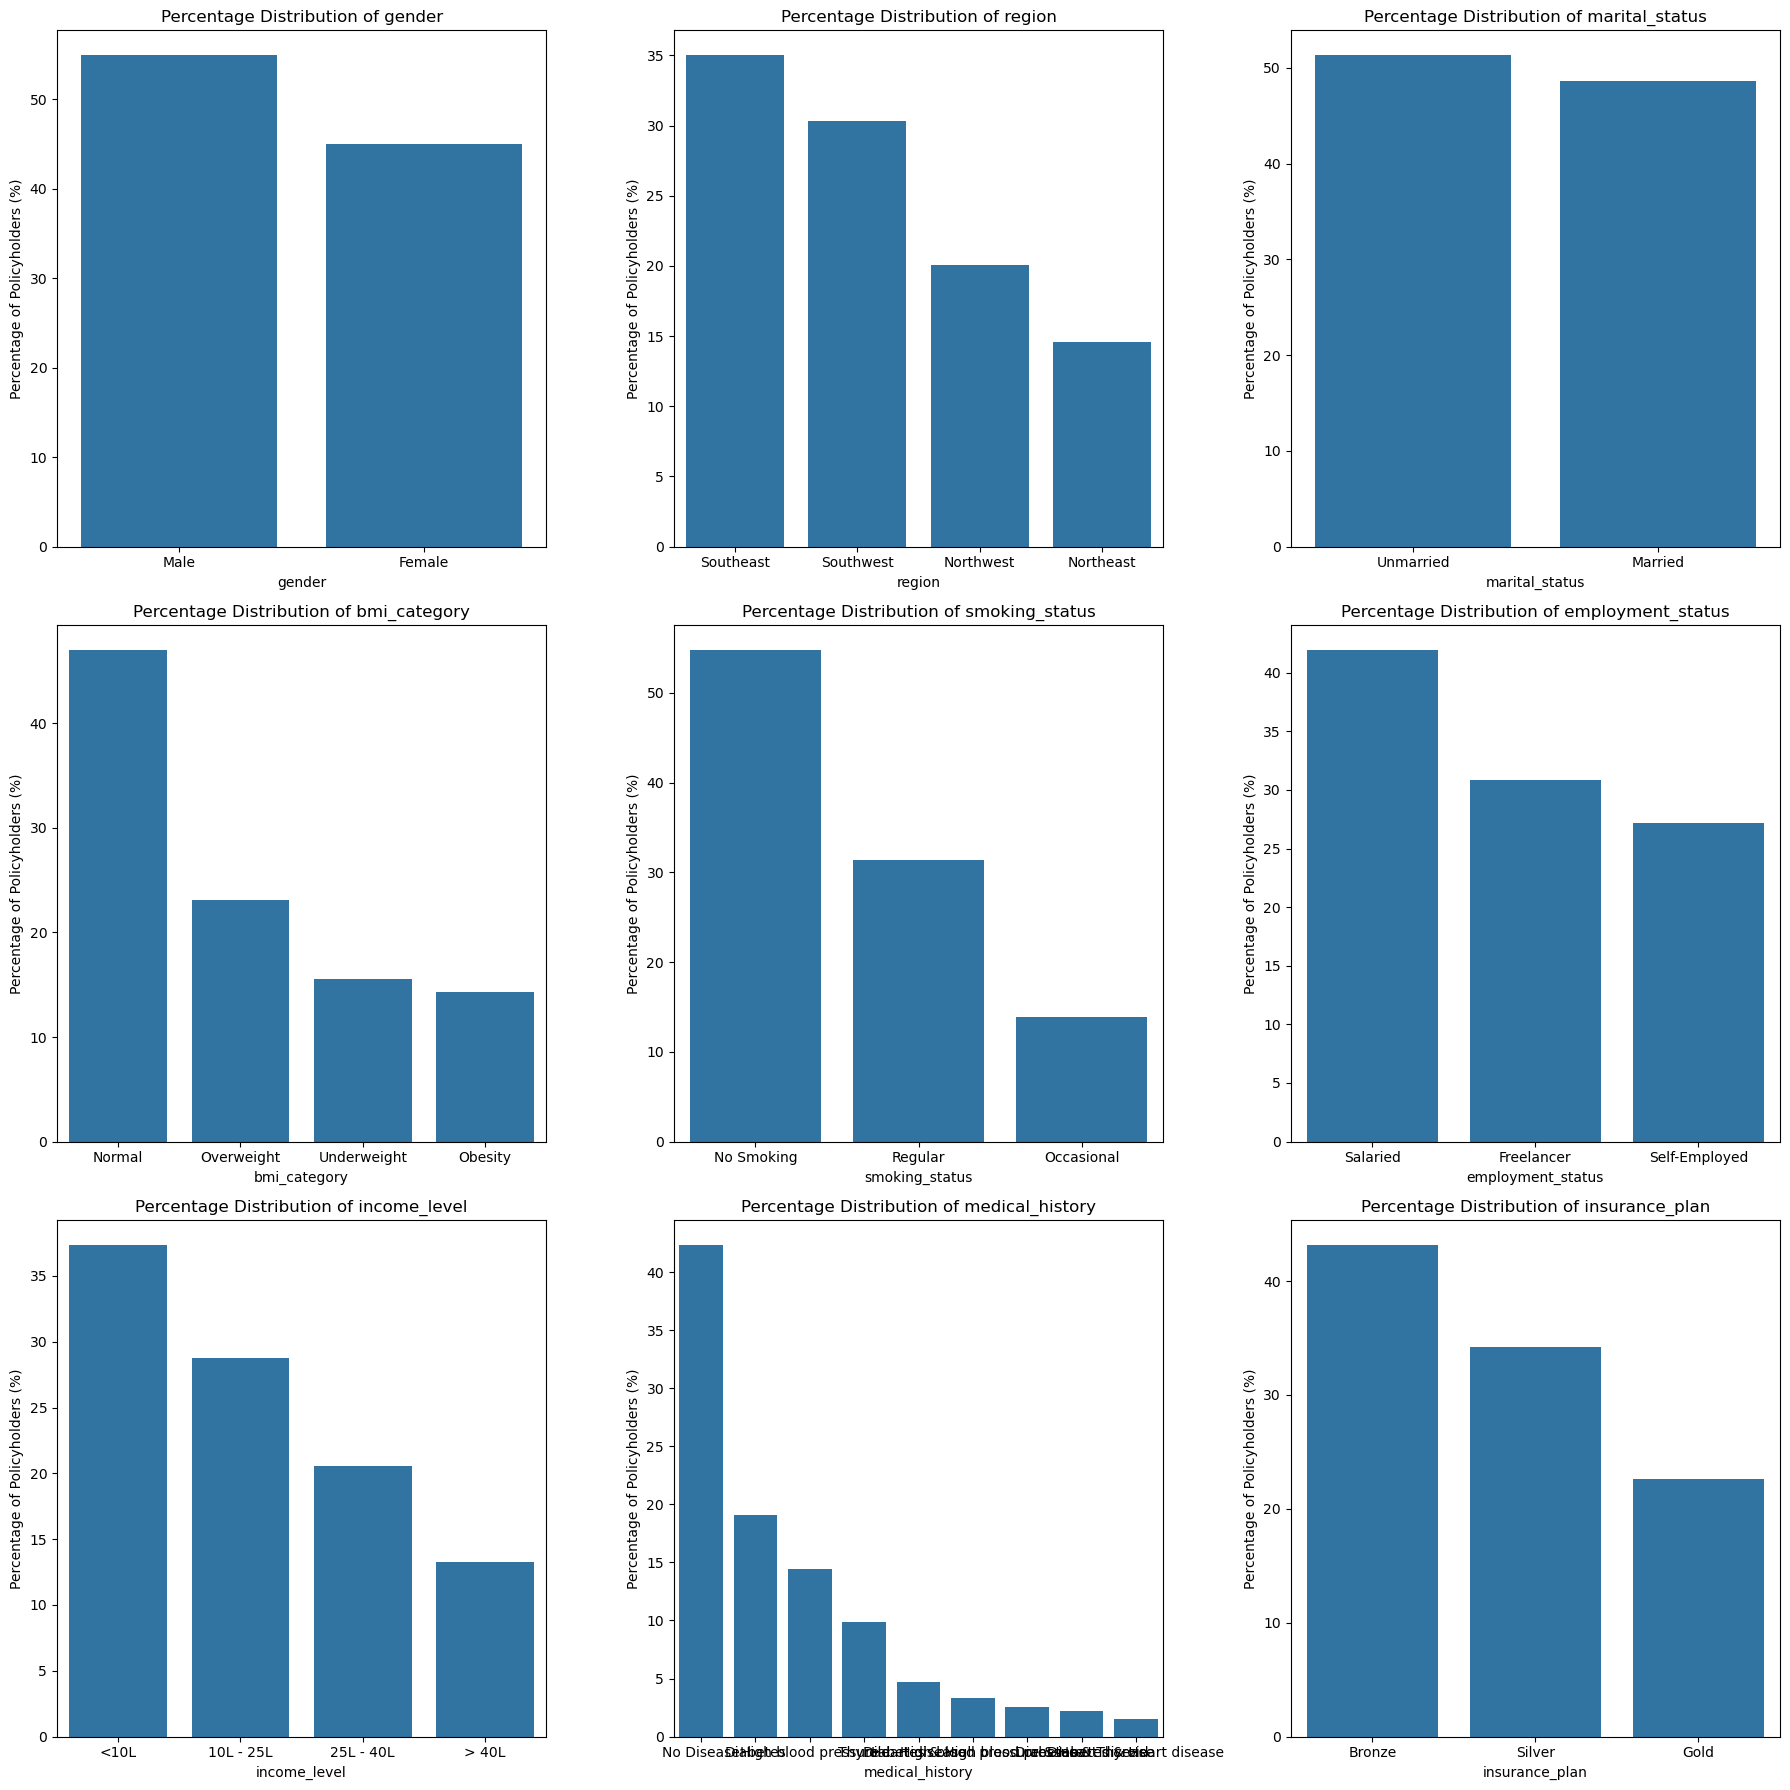

In [52]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_columns):
    category_counts = df2[column].value_counts(normalize=True) * 100
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)

plt.tight_layout()
plt.show()

### Bivariate Analysis: Categorical Columns

In [54]:
# creating a separated dataframe for categorical colums
Category_Data=df2.select_dtypes(include=['object', 'category'])
Category_Data.head(2)

,gender,region,marital_status,bmi_category,smoking_status,employment_status,income_level,medical_history,insurance_plan
0,Male,Northwest,Unmarried,Normal,No Smoking,Salaried,<10L,Diabetes,Bronze
1,Female,Southeast,Married,Obesity,Regular,Salaried,<10L,Diabetes,Bronze


In [55]:
# importing label encoder package
from sklearn.preprocessing import LabelEncoder

# converting categorical column values into numeric
for col in Category_Data.columns:
    le = LabelEncoder()
    Category_Data[col] = le.fit_transform(Category_Data[col])
Category_Data.head(5)

,gender,region,marital_status,bmi_category,smoking_status,employment_status,income_level,medical_history,insurance_plan
0,1,1,1,0,0,1,2,0,0
1,0,2,0,1,2,1,2,0,0
2,0,0,0,0,0,2,0,5,2
3,0,2,0,0,0,1,3,7,1
4,1,0,1,2,2,2,3,5,2


In [56]:
#importing chi-square package
from sklearn.feature_selection import chi2

# seperating target and dependent variable
X = Category_Data.drop(columns=["insurance_plan"], axis =1)
y = Category_Data["insurance_plan"]

In [57]:
# running Chi Square test and storing the values
chi_score = chi2(X,y)
chi_score

(array([2.78902699e+01, 1.53921583e-01, 2.52131800e+03, 6.06332293e+01,
        3.88661123e+02, 1.65751240e+03, 1.69323197e+01, 3.33568034e+03]),
 array([8.78425321e-07, 9.25926157e-01, 0.00000000e+00, 6.81807153e-14,
        4.01152480e-85, 0.00000000e+00, 2.10471595e-04, 0.00000000e+00]))

In [58]:
# Converting chi-squared values
chi_squared_normal = [format(val, ".8f") for val in chi_score[0]]
# Converting p-values
p_values_normal = [format(val, ".8f") for val in chi_score[1]]

print("Chi-Squared Values in Normal Format: ", chi_squared_normal)
print("P-Values in Normal Format: ", p_values_normal)

Chi-Squared Values in Normal Format:  ['27.89026988', '0.15392158', '2521.31800148', '60.63322927', '388.66112297', '1657.51240070', '16.93231971', '3335.68033776']
P-Values in Normal Format:  ['0.00000088', '0.92592616', '0.00000000', '0.00000000', '0.00000000', '0.00000000', '0.00021047', '0.00000000']


<Axes: >

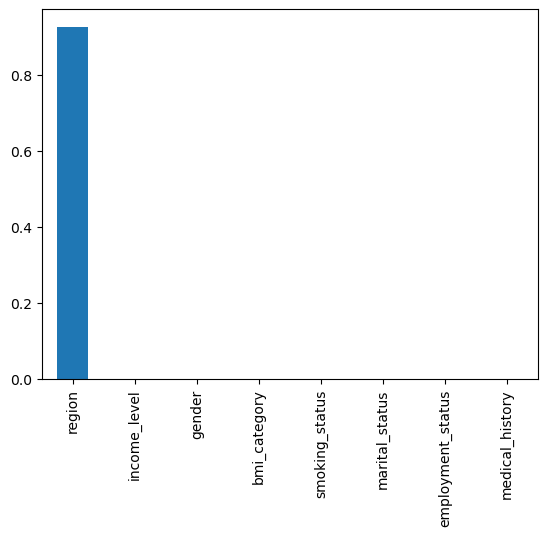

In [59]:
# if P-value > 0.5, Lower the relation significance
P_value = pd.Series(chi_score[1], index = X.columns)
P_value.sort_values(ascending=False, inplace= True)
P_value.plot.bar()

In [60]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df2['medical_history'],df2['insurance_plan'])
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
print(expected)

insurance_plan                       Bronze  Gold  Silver
medical_history                                          
Diabetes                               2687  3058    3788
Diabetes & Heart disease                268   190     281
Diabetes & High blood pressure          587   418     636
Diabetes & Thyroid                      411   272     432
Heart disease                           672   756     915
High blood pressure                    2036  2318    2855
High blood pressure & Heart disease     449   316     508
No Disease                            13056  2355    5727
Thyroid                                1379  1621    1917
Chi-square statistic: 5771.1752
P-value: 0.0000
Degrees of freedom: 16

Expected frequencies:
[[4115.34192915 2159.19355614 3258.46451471]
 [ 319.02210067  167.38110123  252.59679811]
 [ 708.41037509  371.68117336  560.90845155]
 [ 481.33916406  252.54388074  381.1169552 ]
 [1011.45978601  530.68189469  800.85831931]
 [3112.08433518 1632.81509978 2464.10056504

insurance_plan  Bronze  Gold  Silver
region                              
Northeast         3126  1620    2523
Northwest         4356  2254    3418
Southeast         7540  4028    5919
Southwest         6523  3402    5199


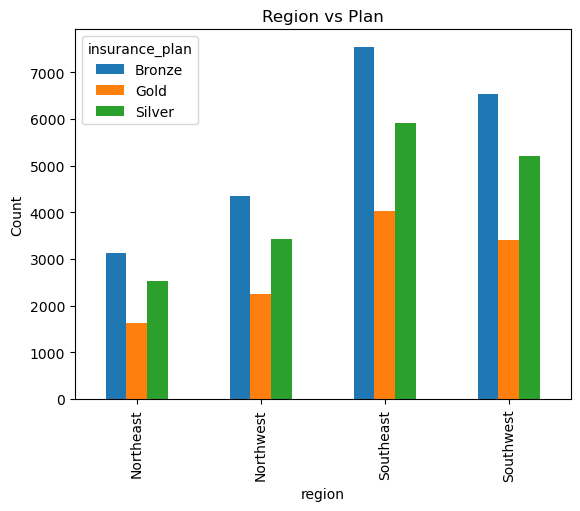

In [61]:
crosstab = pd.crosstab(df2["region"],df2["insurance_plan"])
print(crosstab)

crosstab.plot(kind="bar")
plt.title("Region vs Plan")
plt.ylabel("Count")
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


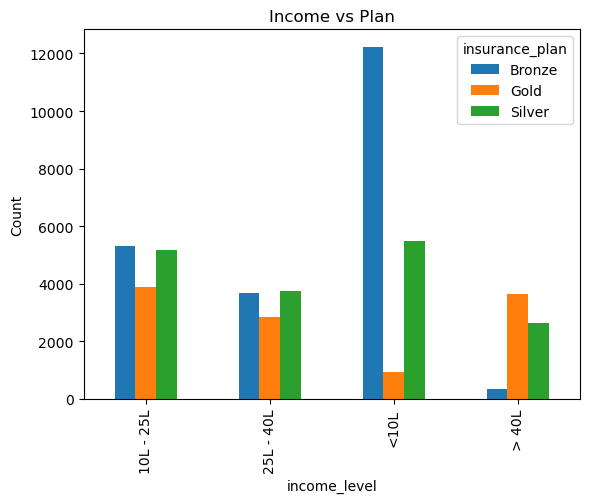

In [62]:
crosstab = pd.crosstab(df2["income_level"],df2["insurance_plan"])
print(crosstab)

crosstab.plot(kind="bar")
plt.title("Income vs Plan")
plt.ylabel("Count")
plt.show()

# Feature Engineering

In [64]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [65]:
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [66]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

In [67]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.lower().str.split(" & ", expand=True).fillna('none')
df2['total_risk_score'] = df2[['disease1', 'disease2']].applymap(risk_scores.get).sum(axis=1)

C:\Users\anikb\AppData\Local\Temp\ipykernel_10260\3162272025.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2['total_risk_score'] = df2[['disease1', 'disease2']].applymap(risk_scores.get).sum(axis=1)


In [68]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6


In [69]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Reshape the column for scaling, as MinMaxScaler expects a 2D array
df2['normalized_risk_score'] = scaler.fit_transform(df2[['total_risk_score']])

In [70]:
# Encode Text Columns

df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [71]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [72]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [73]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1


In [74]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)        

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


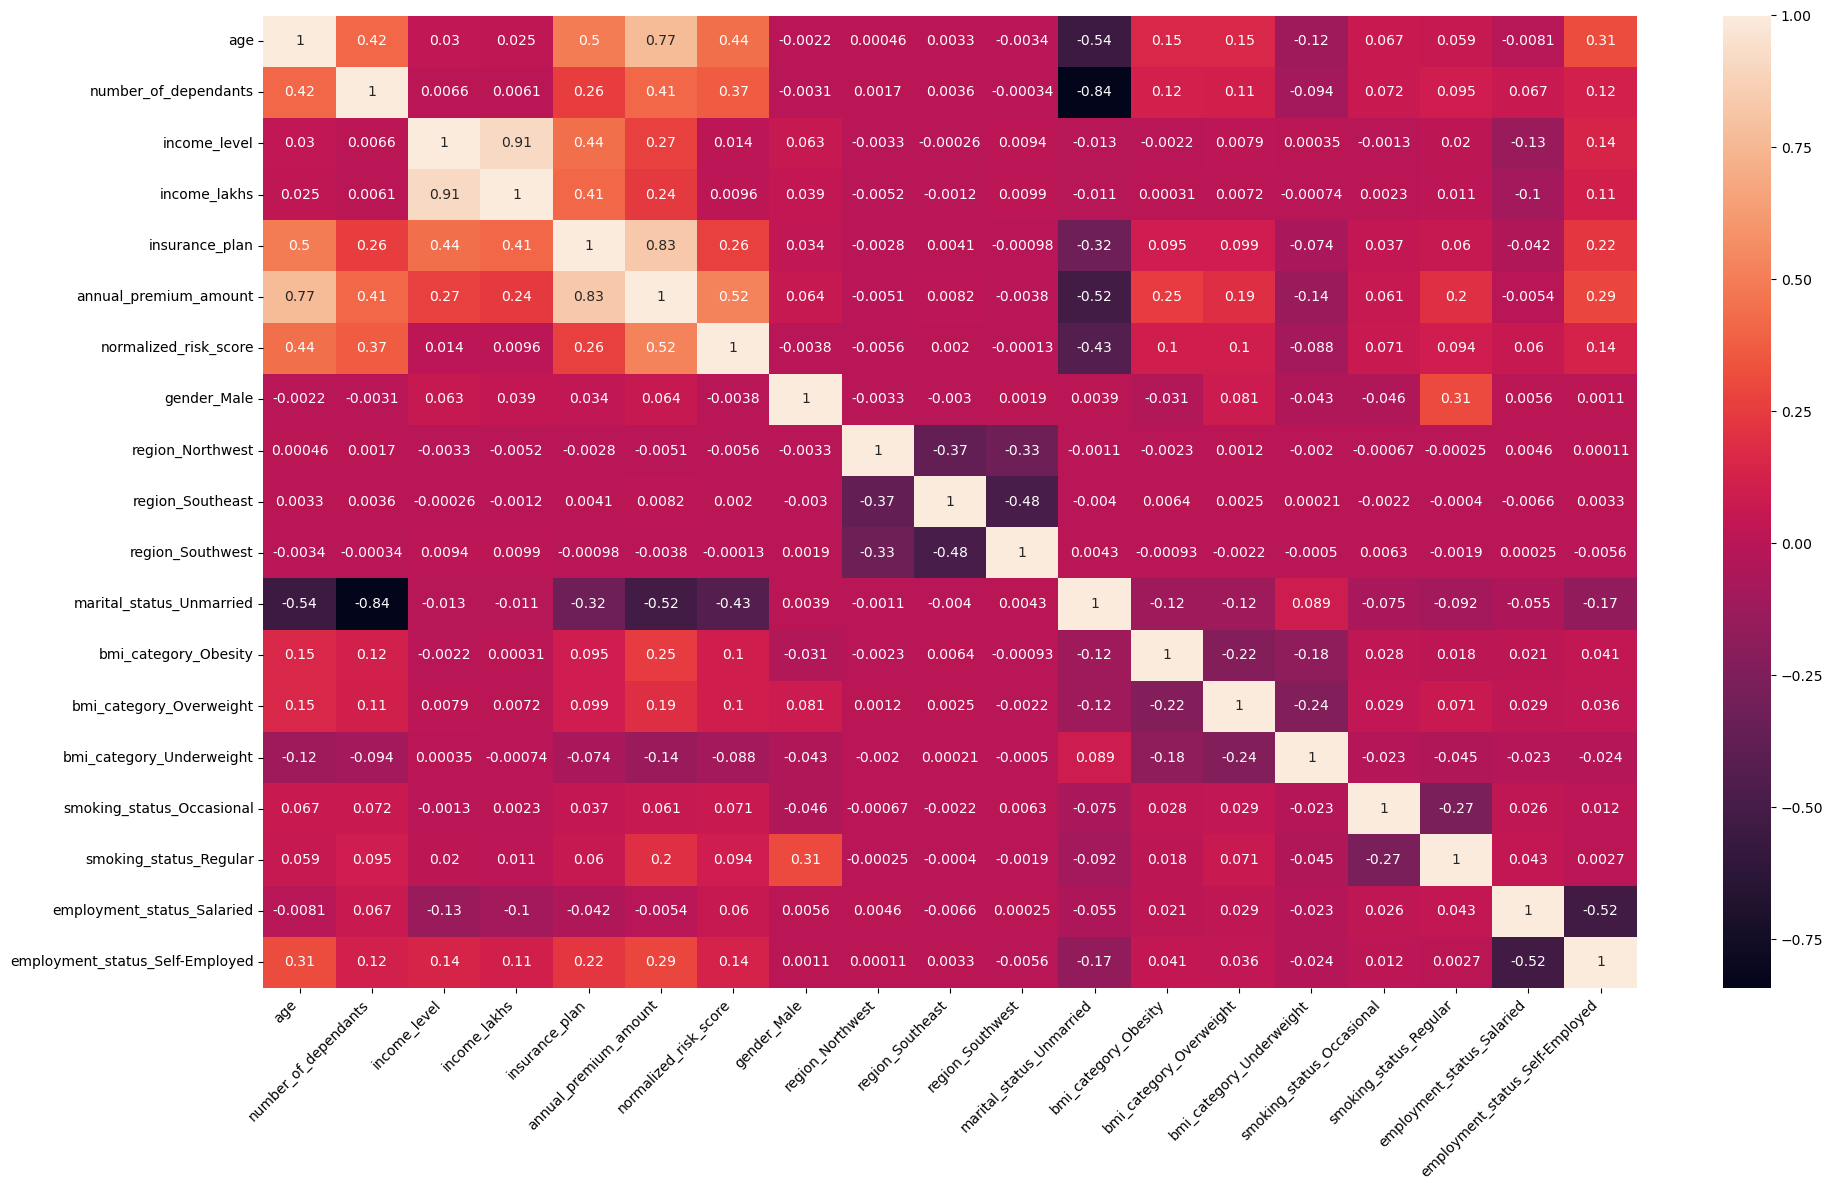

In [75]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [76]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [78]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [79]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [80]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop('income_level', axis="columns")

## Model Building

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (34935, 17)
x test:  (14973, 17)
y train:  (34935,)
y test:  (14973,)


In [82]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


def evaluate_models(X_train, X_test, y_train, y_test):
    # Define models
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso Regression": Lasso(),
        "Ridge Regression": Ridge(),
        "Random Forest Regressor": RandomForestRegressor(random_state=10),
        "XGB Regressor": XGBRegressor(random_state=10)
    }
    
    # List to store metrics data for each model
    metrics_list = []
    coefficients_df = pd.DataFrame()
    coefficients_df['Feature'] = X_train.columns  # Assuming X_train is a DataFrame with column names
    
    # Iterate through models
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        # Append metrics to the list as a dictionary
        metrics_list.append({
            "Model": name,
            "R2 Score": r2,
            "MSE": mse,
            "RMSE": rmse
        })
        
        # Extract and store coefficients or feature importances
        if hasattr(model, 'coef_'):  # Linear, Lasso, and Ridge have coef_ attribute
            coefficients_df[name] = model.coef_
        elif hasattr(model, 'feature_importances_'):  # RandomForest and XGB have feature_importances_
            coefficients_df[name] = model.feature_importances_
    
    # Convert metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    
    return metrics_df, coefficients_df

In [83]:
# Call the function and store the results
metrics_df, coefficients_df = evaluate_models(X_train, X_test, y_train, y_test)

In [84]:
metrics_df

,Model,R2 Score,MSE,RMSE
0,Linear Regression,0.928055,5.165612e+06,2272.798256
1,Lasso Regression,0.928087,5.163289e+06,2272.287065
2,Ridge Regression,0.928054,5.165652e+06,2272.807079
3,Random Forest Regressor,0.979227,1.491474e+06,1221.259155
4,XGB Regressor,0.980953,1.367526e+06,1169.412542


In [85]:
coefficients_df

,Feature,Linear Regression,Lasso Regression,Ridge Regression,Random Forest Regressor,XGB Regressor
0,age,11160.926462,11163.674323,11154.728961,0.589377,0.241309
1,number_of_dependants,-676.443991,-616.276455,-675.899989,0.001644,0.000451
2,income_lakhs,-514.229816,-486.441470,-512.756970,0.006093,0.000486
3,insurance_plan,12557.012936,12547.308722,12555.335224,0.337791,0.634481
4,normalized_risk_score,4810.357702,4803.795841,4809.982132,0.023996,0.025562
5,gender_Male,168.646662,165.595662,168.693260,0.000946,0.000495
6,region_Northwest,-35.719292,-24.512293,-35.724591,0.000641,0.000455
7,region_Southeast,39.965130,43.446010,39.964676,0.000769,0.000434
8,region_Southwest,-24.652929,-15.219594,-24.648628,0.000723,0.000525
9,marital_status_Unmarried,-935.760611,-908.287413,-937.397634,0.000274,0.000450


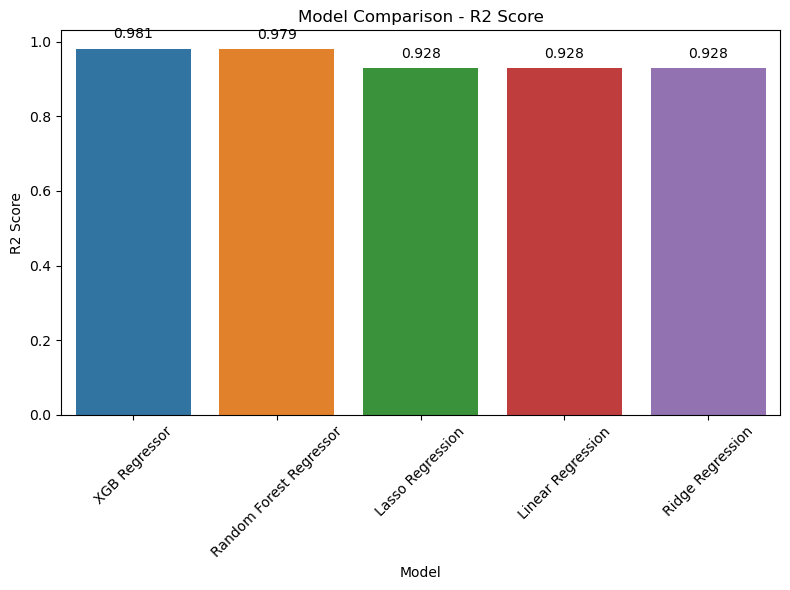

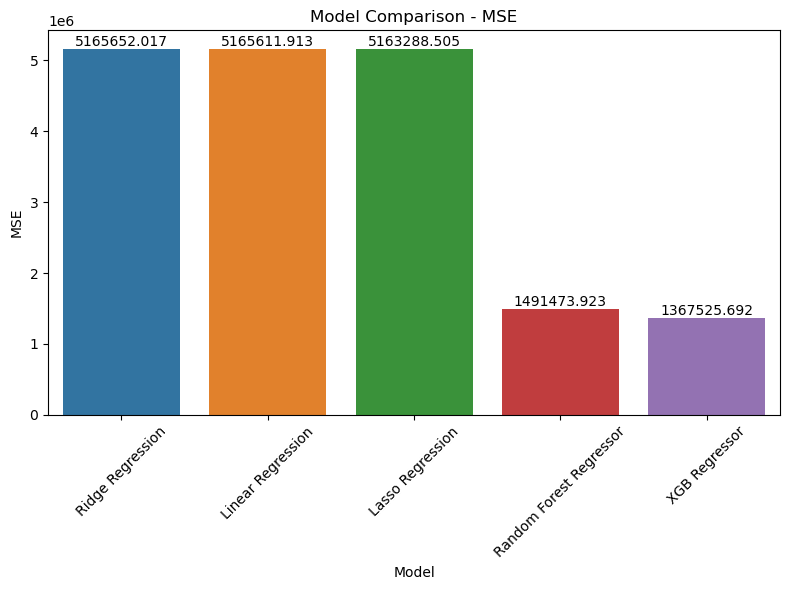

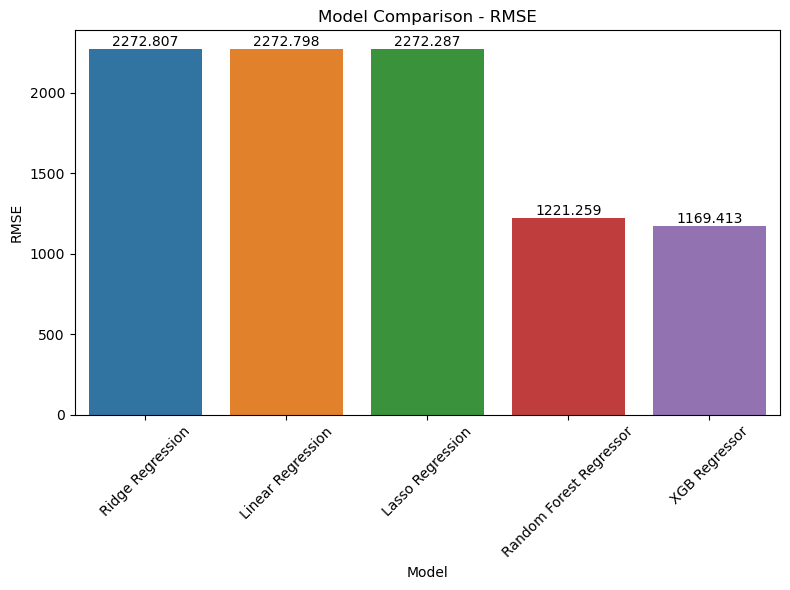

In [86]:
metrics = ['R2 Score', 'MSE', 'RMSE']

for metric in metrics:
    plt.figure(figsize=(8, 6))
    sorted_metrics_df = metrics_df.sort_values(by=metric, ascending=False)
    sns.barplot(x='Model', y=metric, data=sorted_metrics_df, hue='Model', dodge=False, legend=False)
    plt.title(f"Model Comparison - {metric}")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability

    # Add data labels
    for p in plt.gca().patches:
        plt.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.02, f'{p.get_height():.3f}', 
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

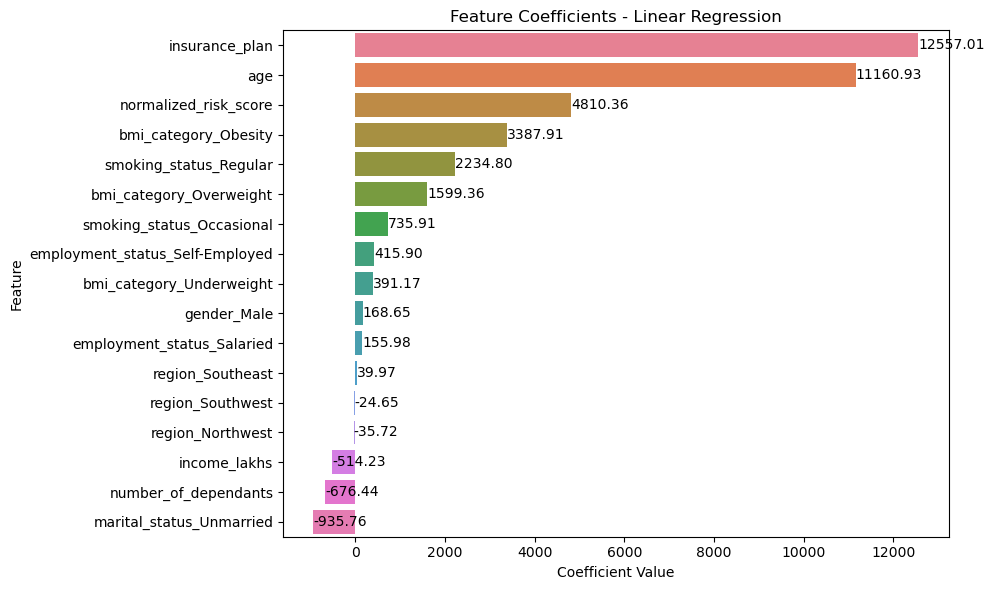

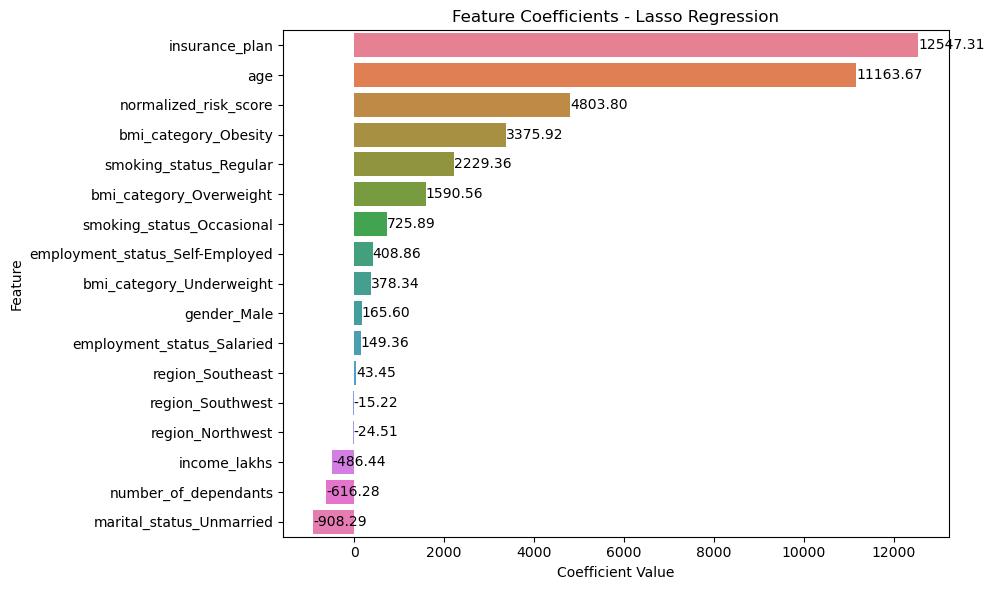

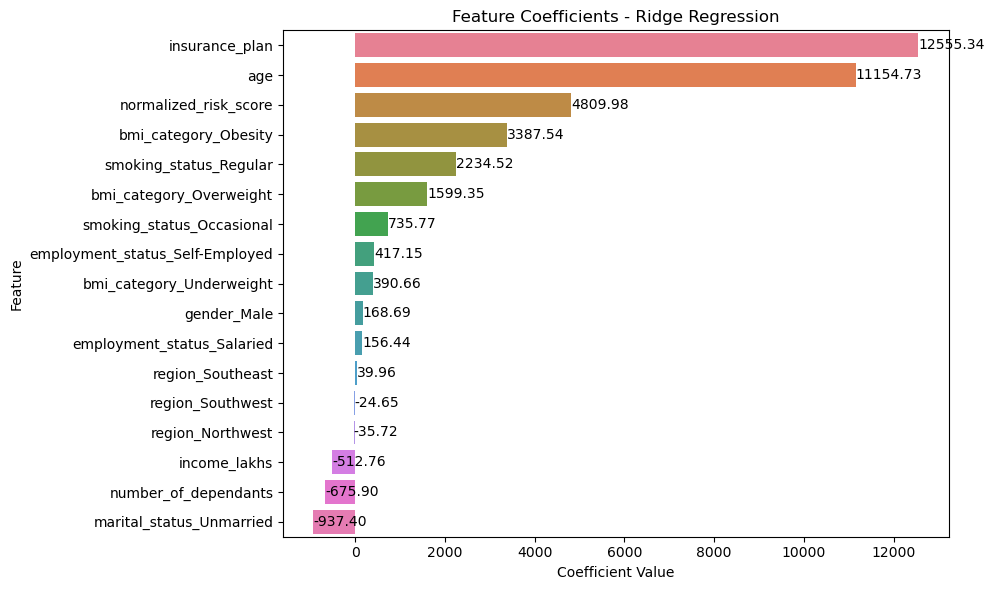

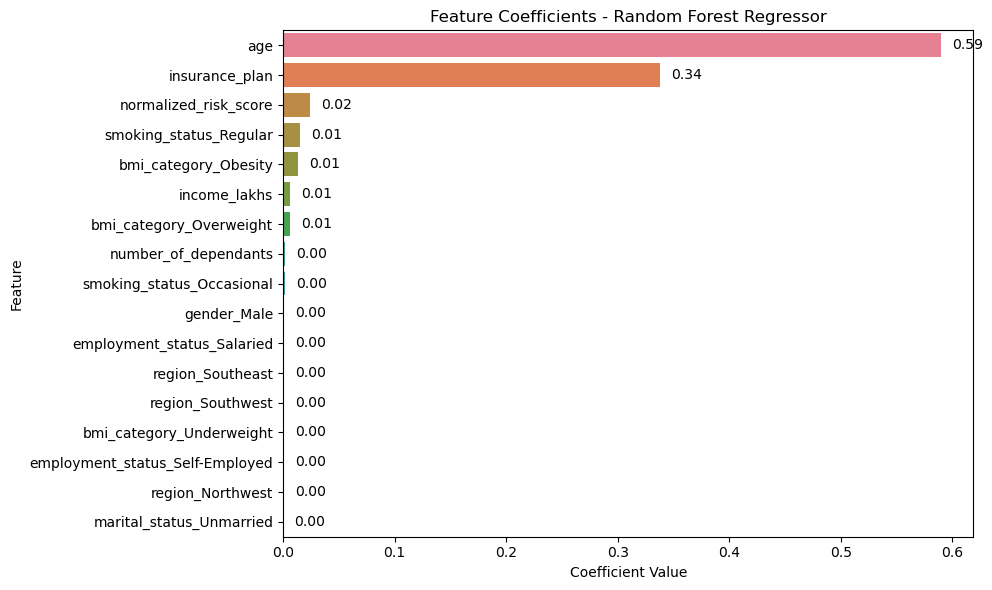

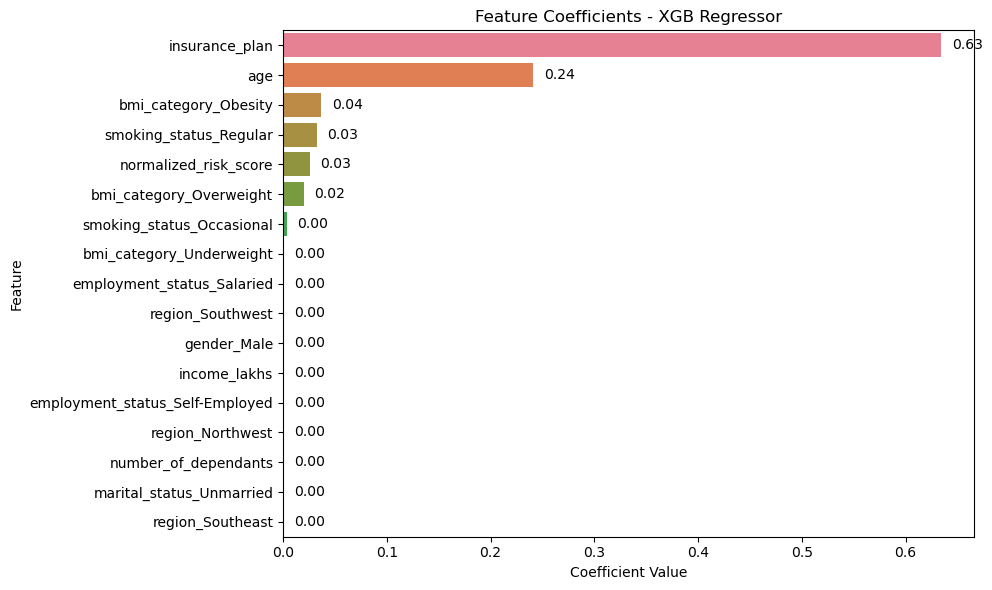

In [87]:
# Transform coefficients_df to long format for easier plotting
coeffs_long = coefficients_df.set_index("Feature").stack().reset_index()
coeffs_long.columns = ["Feature", "Model", "Coefficient"]

# Iterate over each unique model to create a separate plot
for model in coeffs_long['Model'].unique():
    # Filter data for the current model
    model_data = coeffs_long[coeffs_long['Model'] == model].sort_values(by="Coefficient", ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Coefficient", y="Feature", data=model_data, orient="h", hue="Feature", dodge=False, legend=False)
    plt.title(f"Feature Coefficients - {model}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    
    # Add data labels
    for p in plt.gca().patches:
        plt.text(p.get_width() + 0.01, p.get_y() + p.get_height() / 2, f'{p.get_width():.2f}', 
                 ha='left', va='center')

    plt.tight_layout()
    plt.show()

Based on the above result, we chose to proceed with XGB Regressos as it gave the highest Accuracy Score and the fewest Errors among other models.

Now we will try to optimize the model even more by using hyperparameters tunning and K fold cross validation. 

## Model Tunning

In [89]:
from sklearn.model_selection import RandomizedSearchCV, KFold

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Initialize the XGBRegressor
xgb = XGBRegressor()

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up RandomizedSearchCV with XGBRegressor and KFold
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,                    # Number of random parameter settings to try
    scoring='r2',                  # Scoring metric
    cv=kf,                         # KFold cross-validation
    random_state=42,
    n_jobs=-1                      # Use all available CPU cores
)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Display the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R2 Score from CV:", random_search.best_score_)

# Predict on the test set using the best estimator
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the performance on the test set
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Test Set Performance:")
print("R2 Score:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.15, 'gamma': 0.4, 'colsample_bytree': 1.0}
Best R2 Score from CV: 0.9817607836878579
Test Set Performance:
R2 Score: 0.9819026545619383
MSE: 1299374.567941958
RMSE: 1139.9011220022367


We optimized the XGB Regression model, but there wasn't a significant increase in accuracy or a reduction in error. Now, we will investigate why the mean squared error is high. Will this affect our model performance?

## Model Evaluation

In [91]:
difference = y_pred - y_test
difference_pct = (difference/y_test) * 100

test_data_results = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'difference': difference, 
    'difference_pct': difference_pct
})
test_data_results.head()

,actual,predicted,difference,difference_pct
3598,20554,20575.009766,21.009766,0.102217
35794,29647,29546.962891,-100.037109,-0.337427
43608,20560,20474.695312,-85.304688,-0.414906
42730,5018,7370.597656,2352.597656,46.883174
18936,8929,8130.326172,-798.673828,-8.944718


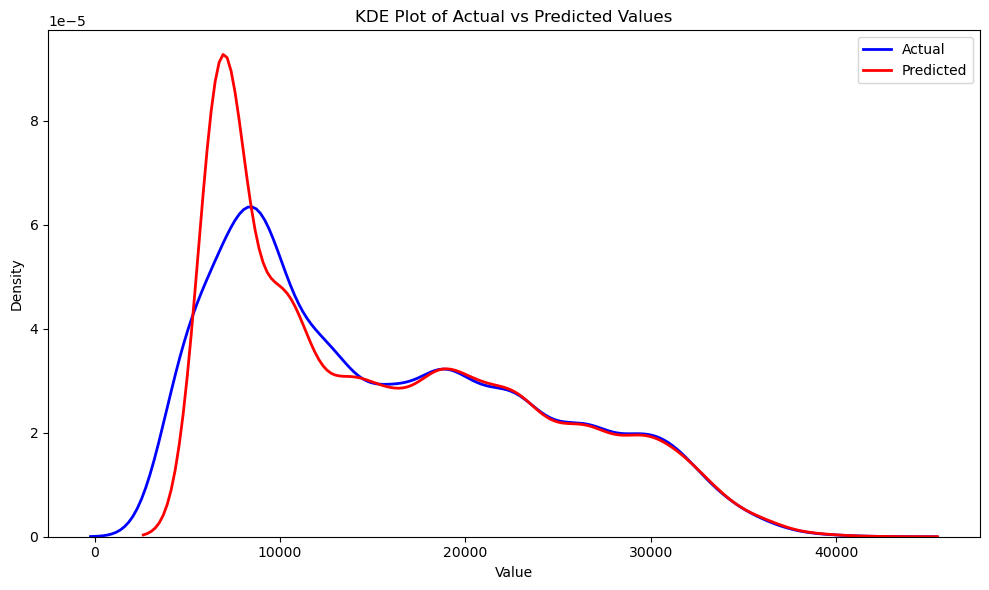

In [92]:
plt.figure(figsize=(10, 6))

# KDE plots for actual and predicted values with labels and colors
sns.kdeplot(test_data_results['actual'], label='Actual', color='blue', linewidth=2)
sns.kdeplot(test_data_results['predicted'], label='Predicted', color='red', linewidth=2)

# Adding title and labels
plt.title("KDE Plot of Actual vs Predicted Values")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

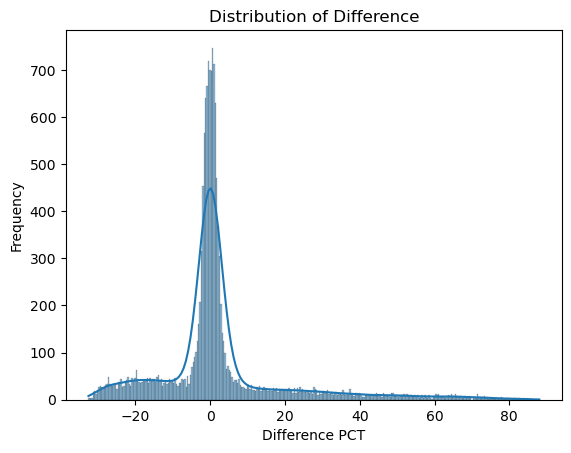

In [93]:
sns.histplot(test_data_results['difference_pct'], kde=True)
plt.title('Distribution of Difference')
plt.xlabel('Difference PCT')
plt.ylabel('Frequency')
plt.show()

In [94]:
test_data_results.shape

(14973, 4)

In [95]:
extreme_error_threshold = 10  # You can adjust this threshold based on your domain knowledge or requirements
extreme_error_data = test_data_results[np.abs(test_data_results['difference_pct']) > extreme_error_threshold]
extreme_error_data.shape

(4394, 4)

In [96]:
error_pct = (extreme_error_data.shape[0]/test_data_results.shape[0])*100
error_pct

29.34615641488012

We can see that 30% of customers' insurance amounts will either be overcharged or undercharged with this model by more than 10% to 90% of the actual amount.

We will now investigate the reasons and locations of the high error percentage.

In [98]:
error_df = X_test.loc[extreme_error_data.index]
error_df.shape

(4394, 17)

In [99]:
error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


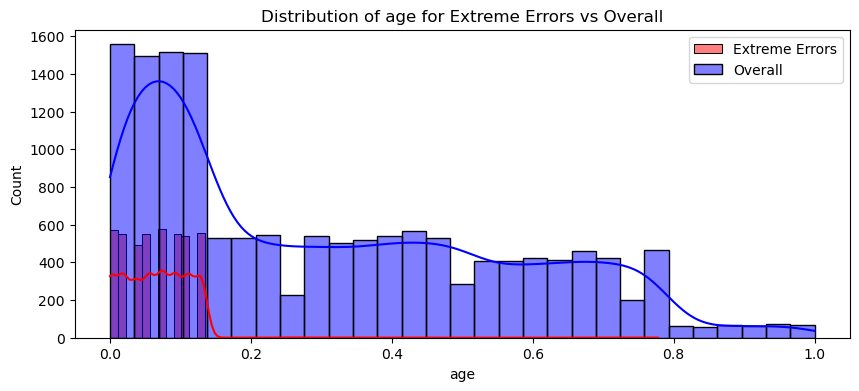

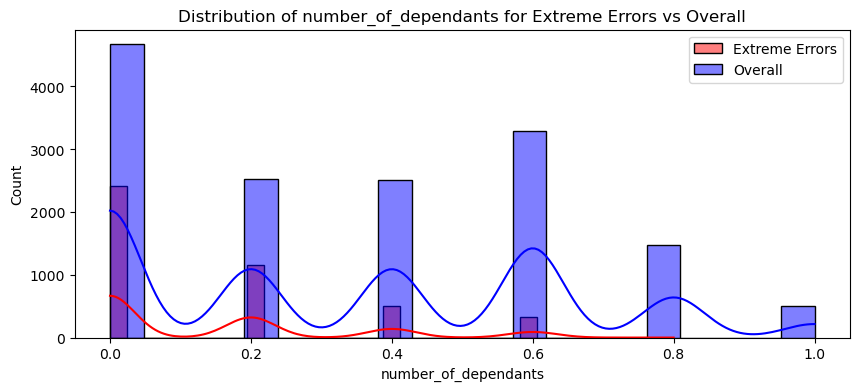

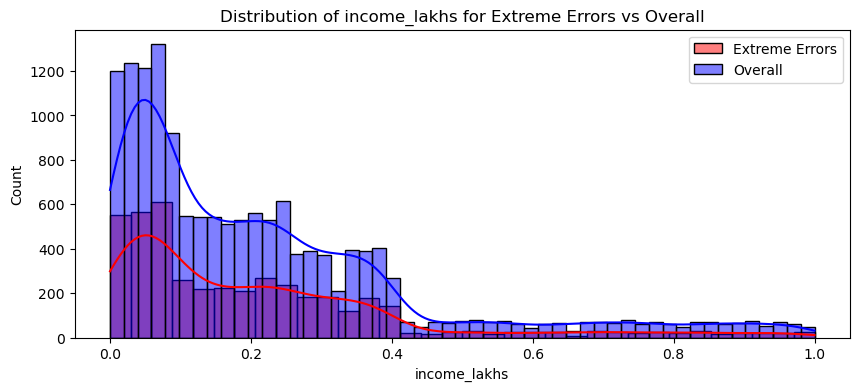

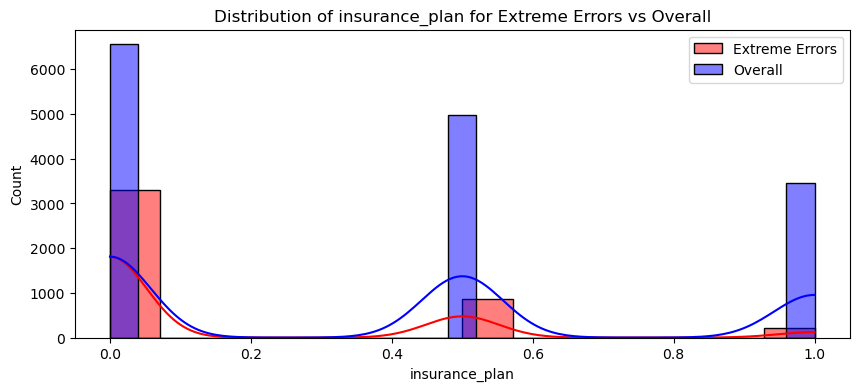

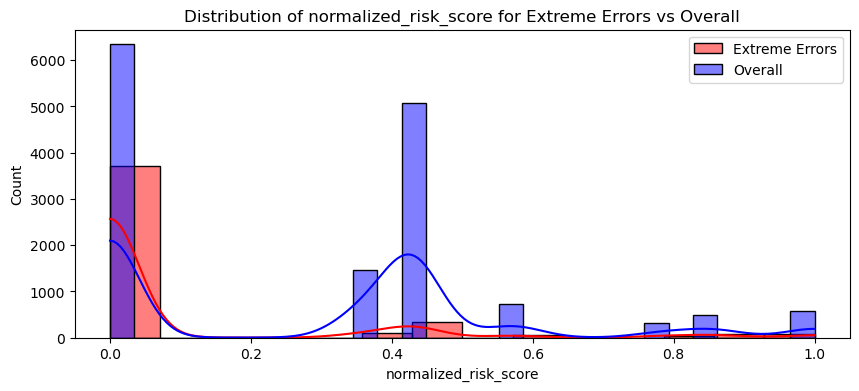

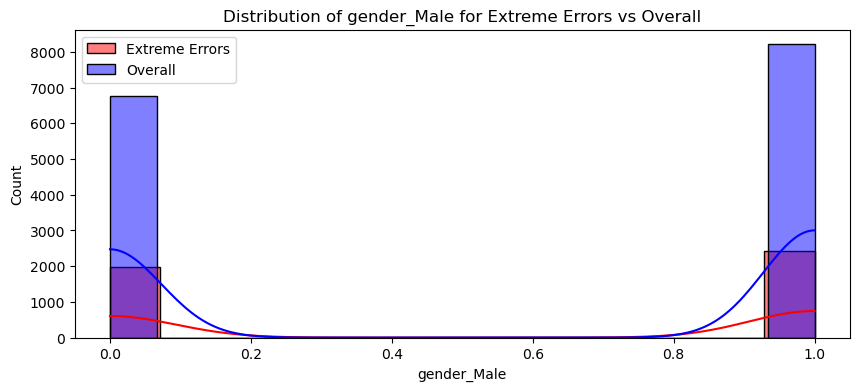

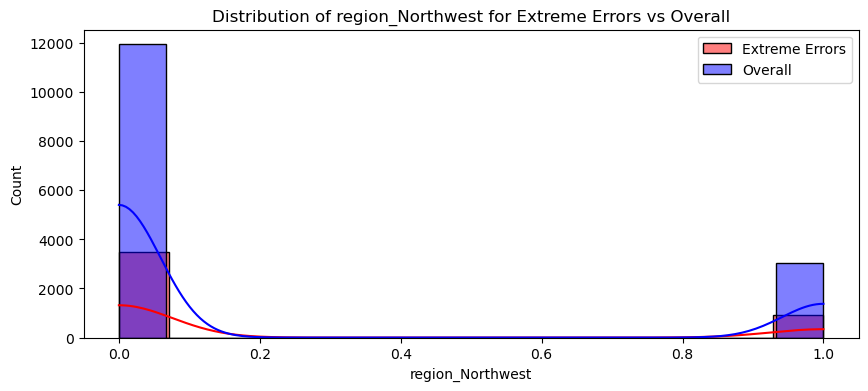

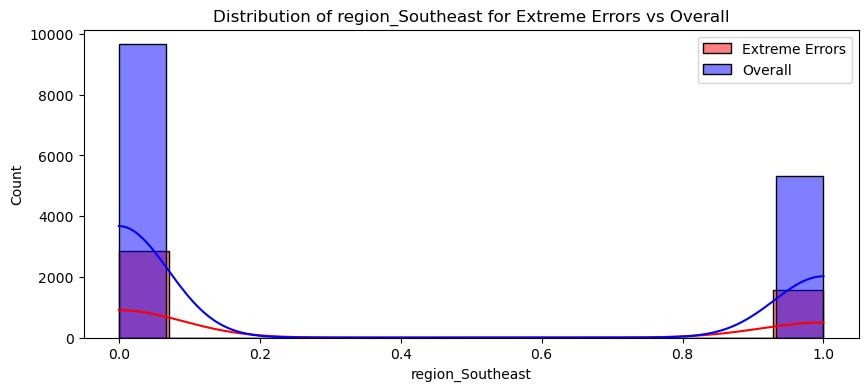

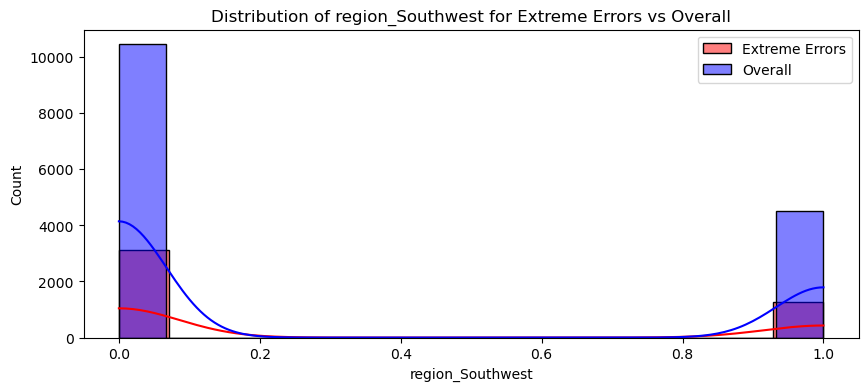

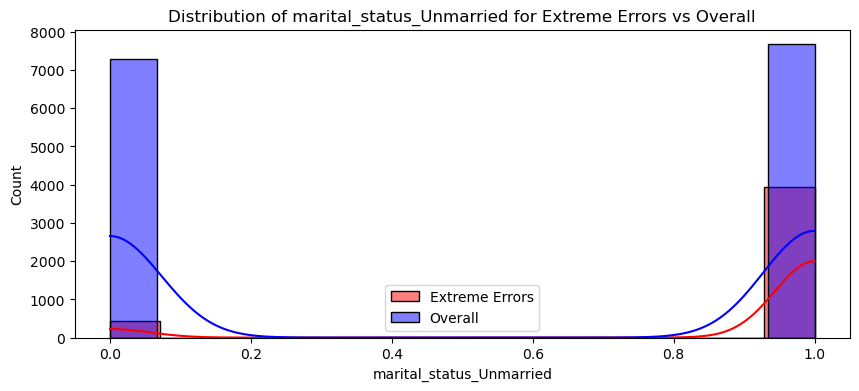

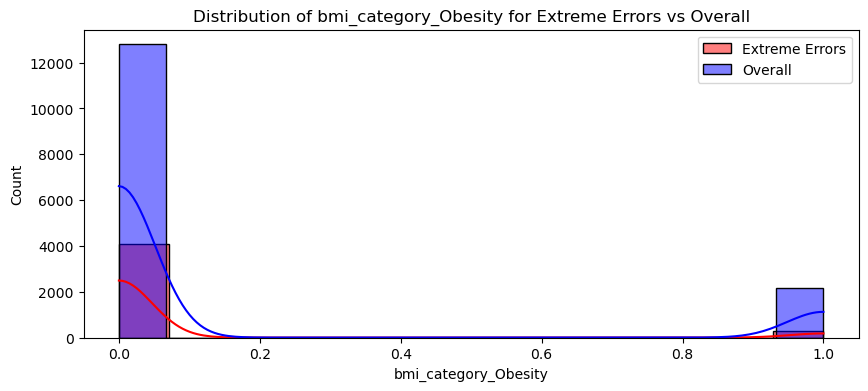

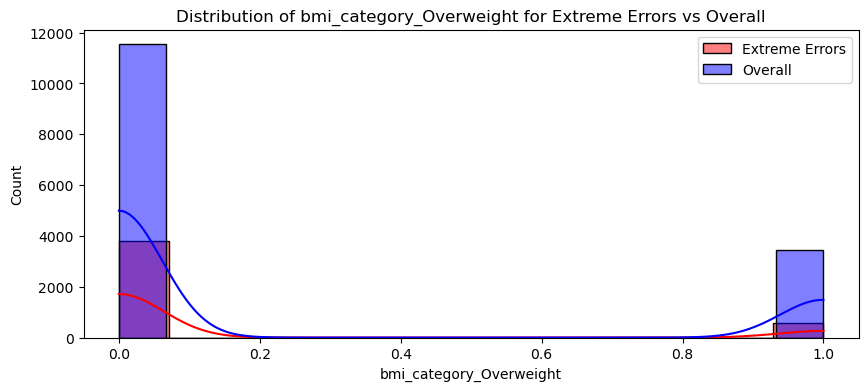

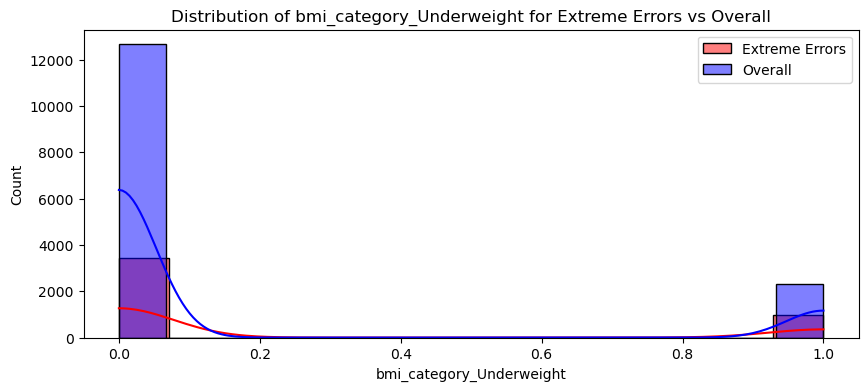

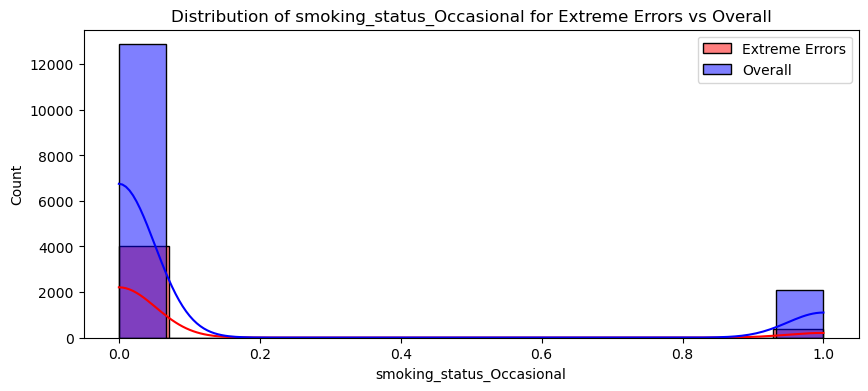

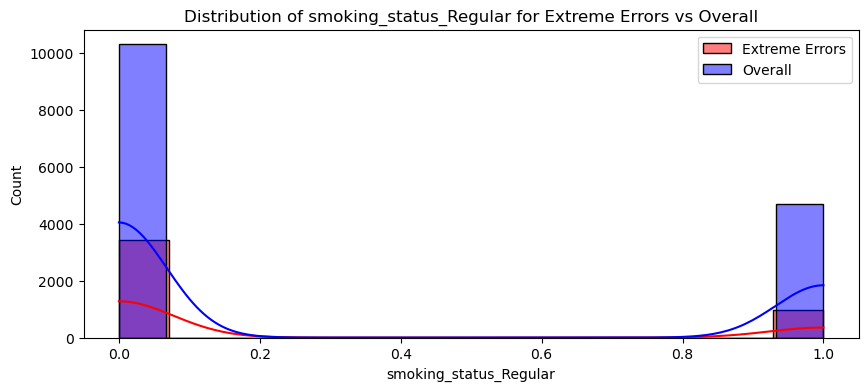

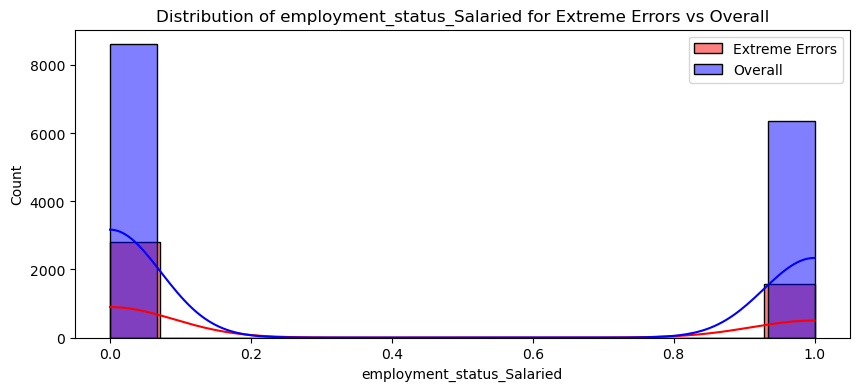

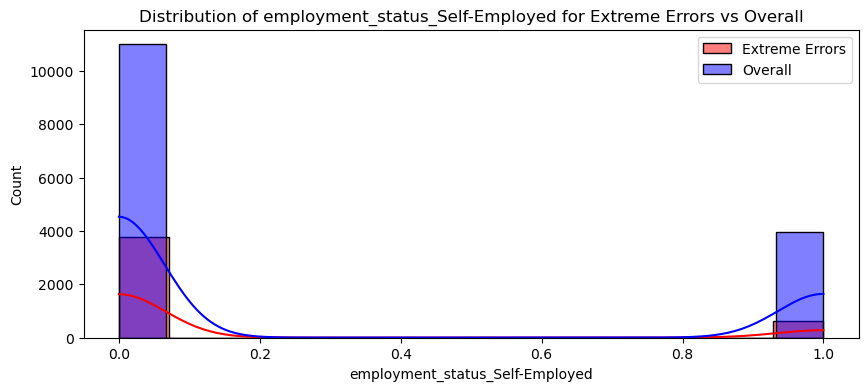

In [100]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(error_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In the bi-variant analysis above, we noticed that the data predicted for younger customers contains more errors than that of other age groups. To understand the error data across different age groups, we will now reverse scale our age data.

In [184]:
error_df['income_level'] = -1

error_df_reversed = pd.DataFrame()
error_df_reversed[cols_to_scale] = scaler.inverse_transform(error_df[cols_to_scale])
error_df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0


In [186]:
error_df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4394.000000,4394.000000,4394.0,4394.000000,4394.000000
mean,21.550296,0.713245,-2.0,21.378926,1.298589
std,2.477552,0.936000,0.0,20.674458,0.557680
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,19.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,1.000000
max,60.000000,4.000000,-2.0,100.000000,3.000000


In [201]:
error_df_reversed['age'].quantile(0.995)

25.0

## Phase 1 Summary:
After training several models on our datasets, we determined that the most effective model was XGB Regression, which achieved an impressive R² score of 98.2% and a mean squared error (MSE) of 1299374. However, the MSE was relatively high, prompting a further analysis of the percentage difference between the actual and predicted insurance amounts. We discovered that approximately 30% of consumers were either overcharged or undercharged by this model, with discrepancies ranging from 10% to 90% of the actual amount. Upon closer investigation, we found that the model struggled to accurately predict values for the 18 to 25 age group. Therefore, we plan to train the model by separating this age group to see how it performs.

## Data Separation

In [211]:
df4.head(5)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [249]:
df5 = df4.drop('income_level', axis="columns")

In [251]:
df5.describe()

,age,number_of_dependants,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,1.794802,15765.739641,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,13.681604,1.492032,22.170699,0.784919,8418.674061,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,18.000000,0.000000,1.000000,1.000000,3501.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,7.000000,1.000000,8608.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.000000,2.000000,17.000000,2.000000,13928.000000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.000000,3.000000,31.000000,2.000000,22270.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,72.000000,5.000000,100.000000,3.000000,43471.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [253]:
age_below_26_df = df5[df5['age']<26]
age_above_25_df = df5[df5['age']>25]

print("Shape of age_below_26_df:", age_below_26_df.shape)
print("Shape of age_above_25_df:", age_above_25_df.shape)

Shape of age_below_26_df: (20086, 18)
Shape of age_above_25_df: (29822, 18)


In [255]:
age_below_26_df.describe()

,age,number_of_dependants,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,1.359156,8141.799263,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,2.294248,0.937238,21.732062,0.600102,2749.912486,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,18.000000,0.000000,1.000000,1.000000,3501.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,6.000000,1.000000,6022.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22.000000,0.000000,16.000000,1.000000,7939.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,23.000000,1.000000,31.000000,2.000000,9561.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,25.000000,3.000000,100.000000,3.000000,18186.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [257]:
age_above_25_df.describe()

,age,number_of_dependants,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,2.088223,20900.689223,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,11.042430,1.420644,22.455408,0.758018,6928.192115,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,26.000000,0.000000,1.000000,1.000000,6538.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,1.000000,7.000000,2.000000,15705.250000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42.000000,3.000000,17.000000,2.000000,20495.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,3.000000,32.000000,3.000000,26360.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,72.000000,5.000000,100.000000,3.000000,43471.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [267]:
X1 = age_below_26_df.drop('annual_premium_amount', axis='columns')
y1 = age_below_26_df['annual_premium_amount']

X2 = age_above_25_df.drop('annual_premium_amount', axis='columns')
y2 = age_above_25_df['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['age','number_of_dependants',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X1[columns_to_scale] = scaler.fit_transform(X1[columns_to_scale])
X2[columns_to_scale] = scaler.fit_transform(X2[columns_to_scale])

print("Shape of X1:", X1.shape)
print("Shape of X2:", X2.shape)

Shape of X1: (20086, 17)
Shape of X2: (29822, 17)


In [273]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=10)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=10)

## Model Performance

In [276]:
# Call the function and store the results
metrics_1_df, coefficients_1_df = evaluate_models(X1_train, X1_test, y1_train, y1_test)
metrics_2_df, coefficients_2_df = evaluate_models(X2_train, X2_test, y2_train, y2_test)

In [278]:
# age below 26 dataset results
metrics_1_df

,Model,R2 Score,MSE,RMSE
0,Linear Regression,0.604759,3.005670e+06,1733.686788
1,Lasso Regression,0.605053,3.003433e+06,1733.041574
2,Ridge Regression,0.604772,3.005574e+06,1733.659126
3,Random Forest Regressor,0.539118,3.504849e+06,1872.124088
4,XGB Regressor,0.563879,3.316549e+06,1821.139473


In [283]:
# age above 25 dataset results
metrics_2_df

,Model,R2 Score,MSE,RMSE
0,Linear Regression,0.953845,2.183844e+06,1477.783597
1,Lasso Regression,0.953841,2.184024e+06,1477.844442
2,Ridge Regression,0.953846,2.183804e+06,1477.769919
3,Random Forest Regressor,0.997691,1.092671e+05,330.555680
4,XGB Regressor,0.997954,9.681422e+04,311.149828


In [287]:
# Fit the RandomizedSearchCV on the training data
random_search.fit(X1_train, y1_train)

# Display the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R2 Score from CV:", random_search.best_score_)

# Predict on the test set using the best estimator
y1_pred = random_search.best_estimator_.predict(X1_test)

# Evaluate the performance on the test set
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y1_test, y1_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y1_test, y1_pred)

print("Test Performance of Below 26 Age Dataset:")
print("R2 Score:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best R2 Score from CV: 0.5962280949061762
Test Performance of Below 26 Age Dataset:
R2 Score: 0.6019078582487942
MSE: 3027351.1767723346
RMSE: 1739.9284976033741


In [289]:
# Fit the RandomizedSearchCV on the training data
random_search.fit(X2_train, y2_train)

# Display the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R2 Score from CV:", random_search.best_score_)

# Predict on the test set using the best estimator
y2_pred = random_search.best_estimator_.predict(X2_test)

# Evaluate the performance on the test set
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y2_test, y2_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y2_test, y2_pred)

print("Test Performance of Below 26 Age Dataset:")
print("R2 Score:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best R2 Score from CV: 0.9981302229392828
Test Performance of Below 26 Age Dataset:
R2 Score: 0.9981037378393692
MSE: 89722.18682380507
RMSE: 299.5366201715661


### Model Performance Summary (Age Below 26):
For the dataset of individuals aged below 26, the Lasso Regression model performed the best among the other models, but the accuracy remains low, achieving an R² score of only 60%.

### Model Performance Summary (Age Above 25):
For the dataset of individuals aged above 25, the XGB Regressor, with hyperparameter tuning, delivered the best performance compared to the other models, achieving an impressive R² score of 99.8%.

Next, we will analyze the percentage differences between the actual and predicted values.

In [312]:
LassoRegression = Lasso()
LassoRegression.fit(X1_train, y1_train)
        
# Predict on test set
y1_pred = LassoRegression.predict(X1_test)


difference = y1_pred - y1_test
difference_pct = (difference/y1_test) * 100

Age_below_26_results = pd.DataFrame({
    'actual': y1_test, 
    'predicted': y1_pred, 
    'difference': difference, 
    'difference_pct': difference_pct
})
Age_below_26_results.head()

,actual,predicted,difference,difference_pct
31773,6238,6637.179866,399.179866,6.399164
36669,9462,7122.205302,-2339.794698,-24.728331
32856,5152,7066.671194,1914.671194,37.163649
35465,6988,7914.332400,926.332400,13.256045
48220,4917,6688.517922,1771.517922,36.028430


In [314]:
difference = y2_pred - y2_test
difference_pct = (difference/y2_test) * 100

Age_above_25_results = pd.DataFrame({
    'actual': y2_test, 
    'predicted': y2_pred, 
    'difference': difference, 
    'difference_pct': difference_pct
})
Age_above_25_results.head()

,actual,predicted,difference,difference_pct
32969,26895,26562.210938,-332.789062,-1.237364
24737,22734,23066.894531,332.894531,1.464303
33333,21198,21537.564453,339.564453,1.601870
49528,9100,9093.549805,-6.450195,-0.070881
28662,26434,26553.308594,119.308594,0.451345


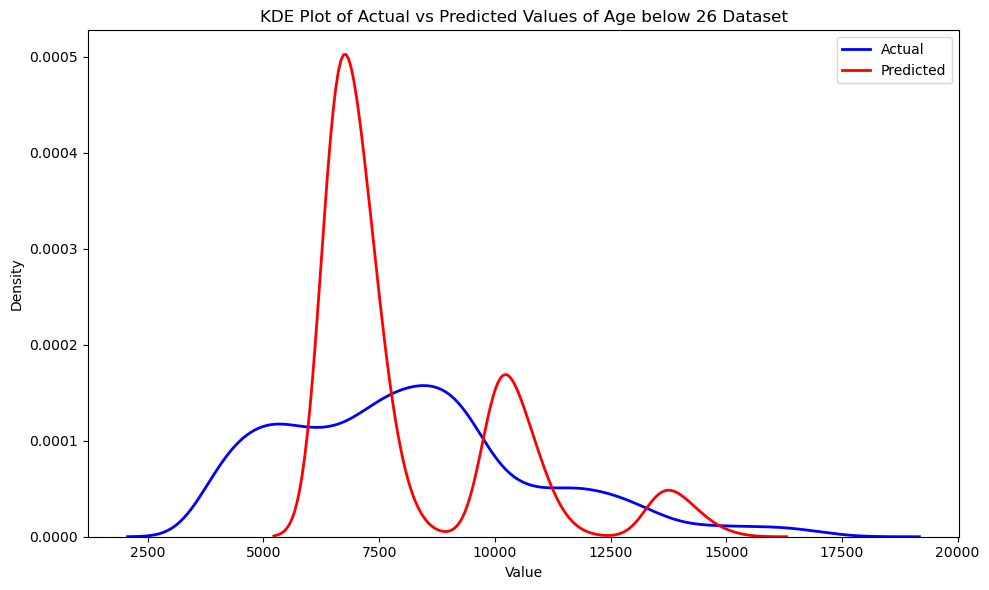

In [316]:
plt.figure(figsize=(10, 6))

# KDE plots for actual and predicted values with labels and colors
sns.kdeplot(Age_below_26_results['actual'], label='Actual', color='blue', linewidth=2)
sns.kdeplot(Age_below_26_results['predicted'], label='Predicted', color='red', linewidth=2)

# Adding title and labels
plt.title("KDE Plot of Actual vs Predicted Values of Age below 26 Dataset")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

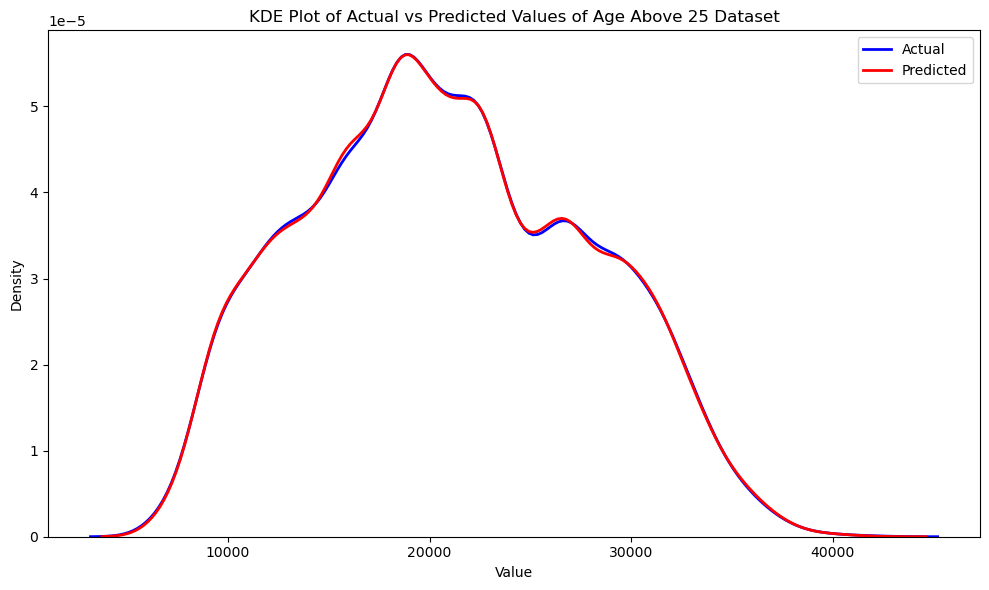

In [318]:
plt.figure(figsize=(10, 6))

# KDE plots for actual and predicted values with labels and colors
sns.kdeplot(Age_above_25_results['actual'], label='Actual', color='blue', linewidth=2)
sns.kdeplot(Age_above_25_results['predicted'], label='Predicted', color='red', linewidth=2)

# Adding title and labels
plt.title("KDE Plot of Actual vs Predicted Values of Age Above 25 Dataset")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

### KDE Plot Analysis Performance Result:
The KDE plot analysis indicates that the prediction results for the age group below 26 are significantly deviating from the actual data, demonstrating poor performance. In contrast, the prediction results for the age group above 26 align closely with the actual data, reflecting solid performance.

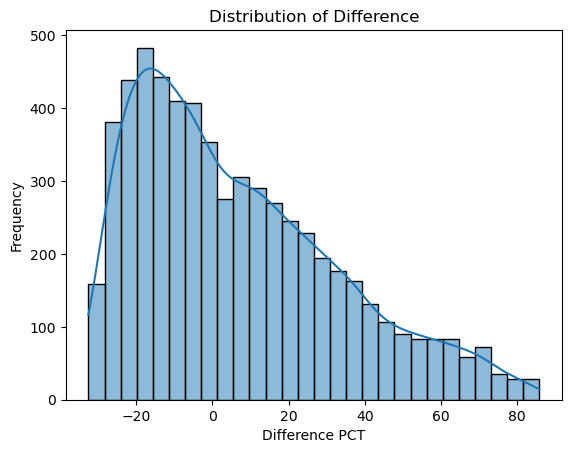

In [323]:
sns.histplot(Age_below_26_results['difference_pct'], kde=True)
plt.title('Distribution of Difference')
plt.xlabel('Difference PCT')
plt.ylabel('Frequency')
plt.show()

In [335]:
extreme_error_threshold = 10  # You can adjust this threshold based on your domain knowledge or requirements
extreme_error_data = Age_below_26_results[np.abs(Age_below_26_results['difference_pct']) > extreme_error_threshold]
error_pct = (extreme_error_data.shape[0]/Age_below_26_results.shape[0])*100
error_pct

73.00033189512114

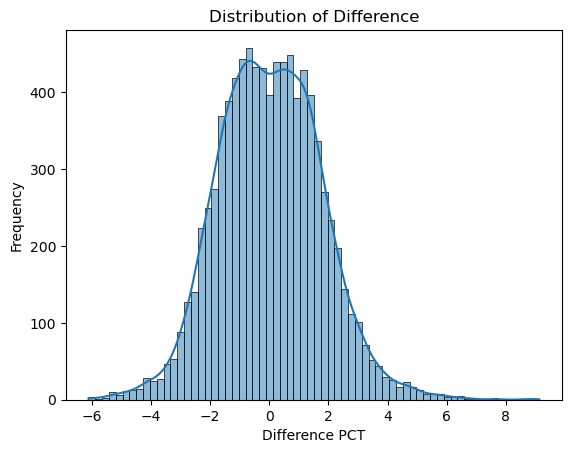

In [326]:
sns.histplot(Age_above_25_results['difference_pct'], kde=True)
plt.title('Distribution of Difference')
plt.xlabel('Difference PCT')
plt.ylabel('Frequency')
plt.show()

In [337]:
extreme_error_threshold = 10  # You can adjust this threshold based on your domain knowledge or requirements
extreme_error_data = Age_above_25_results[np.abs(Age_above_25_results['difference_pct']) > extreme_error_threshold]
error_pct = (extreme_error_data.shape[0]/Age_above_25_results.shape[0])*100
error_pct

0.0

### Difference Percentage Analysis Result:
In our analysis, we have accounted for a 10% margin of error in predicting insurance amounts. For the dataset of consumers aged under 26, over 73% of customers are either overcharged or undercharged by the model, with discrepancies ranging from 10% to 90% of the actual insurance amounts. In contrast, in the dataset of consumers aged 25 and above, there are no individuals who are inaccurately charged more than the established threshold.

# Conclusion
In our two-phase analysis of predicting insurance amounts, we explored multiple models to identify the best approach for different age groups and closely examined the accuracy of predictions, particularly focusing on age-based discrepancies.

#### Phase 1 Summary: 
After training several models on the combined dataset, XGB Regression emerged as the top-performing model, achieving an R² score of 98.2%. However, despite this high R² score, the model had a relatively high mean squared error (MSE), and a deeper analysis revealed that approximately 30% of consumers were either overcharged or undercharged, with discrepancies ranging from 10% to 90%. These inconsistencies were particularly pronounced in the 18 to 25 age group, indicating that the model struggled with accurate predictions for younger individuals. This observation prompted a more granular analysis, where the dataset was split into two segments: individuals below 26 and those above 25.

#### Phase 2 Summary: 
Upon segmenting the data, we observed clear differences in model performance between the two age groups. For individuals below 26, Lasso Regression yielded the best performance among the tested models, but with an R² score of only 60%, indicating a relatively low accuracy and poor predictive capability for this age group. In contrast, for individuals aged above 25, the XGB Regressor—enhanced with hyperparameter tuning—achieved a very high R² score of 99.8%, showcasing strong predictive accuracy and a solid model fit.

##### KDE Plot and Difference Percentage Analysis: 
The KDE plot analysis highlighted that predictions for individuals below 26 deviated significantly from actual values, further confirming the model's subpar performance in this segment. However, for individuals aged above 25, the KDE plot showed close alignment between predicted and actual values, indicating a well-performing model for this group. Further analysis of the percentage differences revealed that over 73% of individuals below 26 were either overcharged or undercharged, with discrepancies ranging from 10% to 90%. For the 25+ age group, however, the model maintained consistency, with no individuals exceeding the established 10% error margin.


#### Recommendations for Improving Predictions for Individuals Below 26:

##### Feature Engineering:
Create new features that may better capture the unique factors affecting younger individuals’ insurance costs, such as lifestyle indicators, risk factors, and employment status. Adding non-linear transformations or interactions between features might also help the model better capture the underlying patterns for this age group.

##### Age-Specific Model Tuning:
Develop a separate model specifically tuned for individuals below 26, rather than using a single model across all ages. This approach allows for more tailored hyperparameter tuning and model selection to optimize performance for younger individuals.

##### Incorporating External Data:
Supplement the existing dataset with external data sources that could provide insights into younger consumers’ behaviors and risks. Data on spending habits, healthcare visits, or even regional information could help refine predictions for this group.

##### Ensemble Methods:
Implement an ensemble model that combines the strengths of different algorithms, such as blending Lasso Regression, Decision Trees, and XGB Regressor for age-specific predictions. Ensemble methods could help balance the predictive strengths across different types of data distributions.

##### Targeted Hyperparameter Tuning:
Perform an extensive hyperparameter search for models specific to the below-26 segment, focusing on parameters that control model complexity (e.g., regularization for Lasso Regression or maximum depth for tree-based models).

##### Handling Outliers and High Variance in Predictions:
Identify and address any outliers in the below-26 dataset that might be skewing predictions. Techniques like quantile regression or robust regression could be used to minimize the influence of extreme values on the model.

#### Final Insights: 
Our analysis indicates that a one-size-fits-all approach may not be ideal for predicting insurance costs across different age groups. While the XGB Regressor performs well for individuals above 25, separate modeling and targeted tuning are necessary for younger consumers to improve prediction accuracy. By implementing age-specific models and incorporating additional features or external data, we can enhance the model’s ability to make fair and accurate predictions across all age groups, ensuring more precise and equitable insurance pricing.